<a href="https://colab.research.google.com/github/VictoriaReiShiro/grid_quality_metrics_pithon/blob/master/3D_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Загрузка файлов с носителя**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Patr_1_3D_k.txt to Patr_1_3D_k.txt


**Преобразование k-файлв в inp и vtu файлы**

Определение типа элементов файла сеточного формата LS-DYNA (*.k)

In [ ]:
import os
# Определение типа элемента в файле модели LS-DYNA и возвращение множества найденных типов элементов
def determ_elem_types(filename):

    element_types_found = set()  # Множество для хранения найденных типов
    current_element_type = None  # Текущий обрабатываемый тип элемента

    with open(filename, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        # Обработка ключевых слов LS-DYNA
        if line.startswith('*'):
            keyword = line.upper()
            if keyword in ['*ELEMENT_BEAM', '*ELEMENT_SHELL', '*ELEMENT_SOLID']:
                current_element_type = keyword
            else:
                current_element_type = None
            i += 1
            continue

        # Пропускаем строки, не относящиеся к элементам
        if current_element_type is None:
            i += 1
            continue

        # Разбор данных элемента
        tokens = line.split()
        if len(tokens) >= 2:
            try:
                EID = int(tokens[0])  # ID элемента
                PID = int(tokens[1])   # ID свойства материала

                # Обработка объёмных элементов элементов
                if current_element_type == '*ELEMENT_SOLID':
                    if len(tokens) >= 10:
                        # Формат в одной строке
                        nodes = [int(n) for n in tokens[2:10] if n.isdigit()]
                    else:
                        # Формат в двух строках
                        i += 1
                        if i < len(lines):
                            next_line = lines[i].strip()
                            nodes = [int(n) for n in next_line.split()[:8] if n.isdigit()]
                        else:
                            nodes = []

                # Обработка поверхностных элементов
                elif current_element_type == '*ELEMENT_SHELL':
                    nodes = [int(n) for n in tokens[2:] if n.isdigit()]

                # Обработка балочных элементов
                elif current_element_type == '*ELEMENT_BEAM':
                    nodes = [int(n) for n in tokens[2:] if n.isdigit()]

                # Определяем уникальные узлы и тип элемента
                unique_nodes = len(set(nodes))
                type_str = get_element_type(current_element_type, unique_nodes)
                element_types_found.add(type_str)
            except (ValueError, IndexError):
                # Пропускаем некорректные строки
                pass
        i += 1
    return element_types_found

def get_element_type(keyword, node_count):
    """
    Возвращает текстовое описание типа элемента на основе ключевого слова и количества узлов
    """
    if keyword == '*ELEMENT_BEAM':
        return beam_types.get(node_count, f'неизвестный тип балки с {node_count} узлами')
    elif keyword == '*ELEMENT_SHELL':
        return shell_types.get(node_count, f'неизвестный тип оболочки с {node_count} узлами')
    elif keyword == '*ELEMENT_SOLID':
        return solid_types.get(node_count, f'неизвестный тип объемного элемента с {node_count} узлами')
    return 'неизвестный тип'

# Словари с описаниями типов элементов
solid_types = {
    4: 'линейный тетраэдр',
    5: 'линейная пирамида',
    6: 'линейная призма',
    8: 'линейный гексаэдр',
    10: 'квадратичный тетраэдр',
    13: 'квадратичная пирамида',
    15: 'квадратичная призма',
    20: 'кубический тетраэдр или квадратичный гексаэдр',
    27: 'триквадратичный гексаэдр или кубическая призма',
    32: 'кубический гексаэдр',
    45: 'трикубическая пирамида',
    54: 'трикубическая призма',
    64: 'трикубический гексаэдр'
}

shell_types = {
    3: 'линейный треугольник',
    4: 'линейный четырехугольник',
    6: 'квадратичный треугольник',
    8: 'квадратичный четырехугольник',
    9: 'биквадратичный четырехугольник',
    12: 'кубический четырехугольник',
    16: 'бикубический четырехугольник'
}

beam_types = {
    2: 'линейная балка',
    3: 'квадратичная балка',
    4: 'кубическая балка'
}

if __name__ == '__main__':
    filename = 'Patr_1_3D.k'  # Путь к файлу модели
    types_found = determ_elem_types(filename)
    print("Найдены следующие типы элементов:")
    for t in sorted(types_found):
        print(f"- {t}")

Найдены следующие типы элементов:
- линейная призма
- линейный гексаэдр


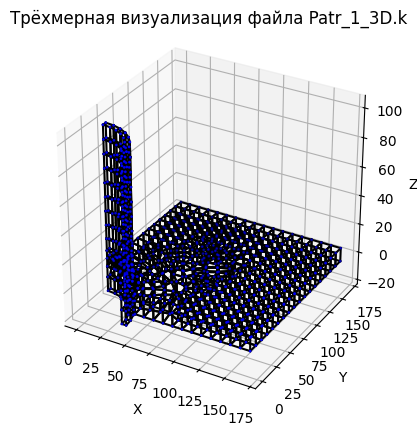

In [ ]:
# Визуализация сетки 3D элементов
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

def p_k_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    nodes = {}
    elements = {}
    curr_section = None
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith('$') or not line:
            i += 1
            continue
        if line.startswith('*'):
            curr_section = line
            i += 1
            continue
        if curr_section == '*NODE':
            parts = line.split()
            if len(parts) >= 4:
                try:
                    index = int(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    z = float(parts[3])
                    nodes[index] = (x, y, z)
                except ValueError:
                    pass
        elif curr_section == '*ELEMENT_SOLID':
            parts = line.split()
            numbers = [p for p in parts if p]
            try:
                if len(numbers) == 10:
                    element_index = int(numbers[0])
                    part = int(numbers[1])
                    node_indices = [int(n) for n in numbers[2:10]]
                    elements[element_index] = node_indices
                elif len(numbers) == 2:
                    element_index = int(numbers[0])
                    part = int(numbers[1])
                    i += 1
                    while i < len(lines):
                        next_line = lines[i].strip()
                        if next_line.startswith('$') or not next_line:
                            i += 1
                            continue
                        node_parts = next_line.split()
                        node_indices = [int(n) for n in node_parts if n][:8]
                        elements[element_index] = node_indices
                        break
            except ValueError:
                pass
        i += 1
    return nodes, elements

def visualiz_mesh(nodes, elements):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Узлы построения графика
    x_nodes = [coord[0] for coord in nodes.values()]
    y_nodes = [coord[1] for coord in nodes.values()]
    z_nodes = [coord[2] for coord in nodes.values()]
    ax.scatter(x_nodes, y_nodes, z_nodes, color='blue', s=1)

    # Ребра шестигранника
    edges = [
        (0,1), (1,2), (2,3), (3,0),  # Нижняя грань
        (4,5), (5,6), (6,7), (7,4),  # Верхняя грань
        (0,4), (1,5), (2,6), (3,7)   # Вертикальные рёбра
    ]

    for element_index, node_indices in elements.items():
        if len(node_indices) != 8:
            continue
        try:
            coords = [nodes[node] for node in node_indices]
        except KeyError:
            continue
        for edge in edges:
            p1 = coords[edge[0]]
            p2 = coords[edge[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='black')

            plt.title('Трёхмерная визуализация файла Patr_1_3D.k')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            # Установка равного масштаба по осям
            ax.set_box_aspect([1, 1, 1])  # Соотношение осей 1:1:1

    plt.show()

if __name__ == "__main__":
    filename = 'Patr_1_3D.k'
    nodes, elements = p_k_file(filename)
    visualiz_mesh(nodes, elements)

Пояснения:
1. расчёт объёма для гексаэдров и призм реализуется с помощью разбиение на тетраэдры с последующим суммированием их объёмов.
2. расчёт углов: для гексаэдров вычисляются углы между рёбрами на каждой четырёхугольной грани, для призм анализируются углы в треугольных и четырёхугольных гранях.
3. расчёт определителя якобиана: для гексаэдров и призм используется упрощённый подход с вычислением в центре элемента.
4. k-файл не хранит в себе информацию необходимую для вычисления КМ кривизна границ, число обусловленности, погрешность аппроксимации.
5. Отношение радиусов реализуемо для тетраэдров/гексаэдров.
6. Отношение диалоналей реализуемо для гексаэдров
7. Кэффициент искажения можно посчитать на основе якобиана






Метрики качества сетки (первые 10 элементов):
+------+----------+----------------+-----------+-------------+-------------+------------+----------------+------------------+--------------+-----------------+----------------------+--------------------+-------------------+----------------------+----------------+
|   ID |   Volume |   Aspect Ratio |   Stretch | Min Angle   | Max Angle   |   Jacobian |   Radius Ratio |   Diagonal Ratio |   Form Coeff |   Gradient Size |   Connectivity Index |   Distortion Coeff |   Face Area Ratio |   Orientation Metric |   Eccentricity |
+======+==========+================+===========+=============+=============+============+================+==================+==============+=================+======================+====================+===================+======================+================+
|    1 |   865.79 |           1.51 |      1.51 | 83.8°       | 96.3°       |     152.00 |           1.01 |             1.01 |         0.69 |            1.29 |      

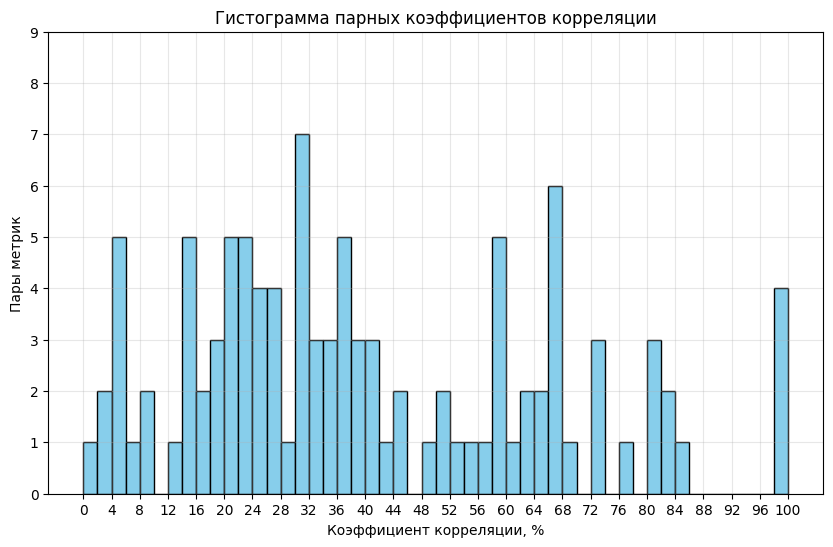

In [ ]:
# Анализ КМ и сокращение метрик
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
from tabulate import tabulate


def volume_tet(vertices):
    v0, v1, v2, v3 = [np.array(v) for v in vertices]
    a = v1 - v0
    b = v2 - v0
    c = v3 - v0
    cross = np.cross(b, c)
    dot = np.dot(a, cross)
    return abs(dot) / 6.0

def volume_hex(vertices):
    tet_indices = [
        [0, 1, 2, 4],
        [1, 2, 4, 5],
        [2, 4, 5, 6],
        [1, 2, 3, 6],
        [1, 5, 6, 2]
    ]
    total_volume = 0.0
    for indices in tet_indices:
        tet_vertices = [vertices[i] for i in indices]
        total_volume += volume_tet(tet_vertices)
    return total_volume

def volume_prism(vertices):
    tet_indices = [
        [0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5]
    ]
    total_volume = 0.0
    for indices in tet_indices:
        tet_vertices = [vertices[i] for i in indices]
        total_volume += volume_tet(tet_vertices)
    return total_volume

def angles_tet(vertices):
    faces = [[0,1,2], [0,1,3], [0,2,3], [1,2,3]]
    angles = []
    for face in faces:
        A, B, C = [np.array(vertices[i]) for i in face]
        AB = B - A
        AC = C - A
        cos_angleA = np.dot(AB, AC) / (np.linalg.norm(AB) * np.linalg.norm(AC))
        angleA = np.degrees(np.arccos(np.clip(cos_angleA, -1.0, 1.0)))

        BA = A - B
        BC = C - B
        cos_angleB = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
        angleB = np.degrees(np.arccos(np.clip(cos_angleB, -1.0, 1.0)))

        CA = A - C
        CB = B - C
        cos_angleC = np.dot(CA, CB) / (np.linalg.norm(CA) * np.linalg.norm(CB))
        angleC = np.degrees(np.arccos(np.clip(cos_angleC, -1.0, 1.0)))

        angles.extend([angleA, angleB, angleC])
    return min(angles), max(angles)

def angles_hex(vertices):
    # Для гексаэдра анализируем углы между рёбрами на каждой грани
    faces = [
        [0,1,2,3], [4,5,6,7], [0,1,5,4],
        [1,2,6,5], [2,3,7,6], [3,0,4,7]
    ]
    angles = []
    for face in faces:
        # Для каждой четырёхугольной грани проверяем углы
        for i in range(4):
            A = np.array(vertices[face[i]])
            B = np.array(vertices[face[(i+1)%4]])
            C = np.array(vertices[face[(i+2)%4]])
            BA = A - B
            BC = C - B
            cos_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
            angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
            angles.append(angle)
    return min(angles), max(angles)

def angles_prism(vertices):
    # Для призмы анализируем углы в треугольных и четырёхугольных гранях
    tri_faces = [[0,1,2], [3,4,5]]
    quad_faces = [[0,1,4,3], [1,2,5,4], [2,0,3,5]]
    angles = []

    # Углы в треугольных гранях
    for face in tri_faces:
        A, B, C = [np.array(vertices[i]) for i in face]
        AB = B - A
        AC = C - A
        cos_angleA = np.dot(AB, AC) / (np.linalg.norm(AB) * np.linalg.norm(AC))
        angleA = np.degrees(np.arccos(np.clip(cos_angleA, -1.0, 1.0)))
        angles.append(angleA)

        BA = A - B
        BC = C - B
        cos_angleB = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
        angleB = np.degrees(np.arccos(np.clip(cos_angleB, -1.0, 1.0)))
        angles.append(angleB)

        CA = A - C
        CB = B - C
        cos_angleC = np.dot(CA, CB) / (np.linalg.norm(CA) * np.linalg.norm(CB))
        angleC = np.degrees(np.arccos(np.clip(cos_angleC, -1.0, 1.0)))
        angles.append(angleC)

    # Углы в четырёхугольных гранях
    for face in quad_faces:
        for i in range(4):
            A = np.array(vertices[face[i]])
            B = np.array(vertices[face[(i+1)%4]])
            C = np.array(vertices[face[(i+2)%4]])
            BA = A - B
            BC = C - B
            cos_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
            angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
            angles.append(angle)

    return min(angles), max(angles)

def jacobian_det_tet(vertices):
    v0, v1, v2, v3 = [np.array(v) for v in vertices]
    a = v1 - v0
    b = v2 - v0
    c = v3 - v0
    J = np.vstack((a, b, c)).T
    return np.linalg.det(J)

def jacobian_det_hex(vertices):
    xi, eta, zeta = 0.0, 0.0, 0.0  # Центральная точка
    dN_dxi = np.array([-1, 1, 1, -1, -1, 1, 1, -1]) * 0.125
    dN_deta = np.array([-1, -1, 1, 1, -1, -1, 1, 1]) * 0.125
    dN_dzeta = np.array([-1, -1, -1, -1, 1, 1, 1, 1]) * 0.125

    dx_dxi = np.sum([dN_dxi[i] * vertices[i][0] for i in range(8)])
    dy_dxi = np.sum([dN_dxi[i] * vertices[i][1] for i in range(8)])
    dz_dxi = np.sum([dN_dxi[i] * vertices[i][2] for i in range(8)])

    dx_deta = np.sum([dN_deta[i] * vertices[i][0] for i in range(8)])
    dy_deta = np.sum([dN_deta[i] * vertices[i][1] for i in range(8)])
    dz_deta = np.sum([dN_deta[i] * vertices[i][2] for i in range(8)])

    dx_dzeta = np.sum([dN_dzeta[i] * vertices[i][0] for i in range(8)])
    dy_dzeta = np.sum([dN_dzeta[i] * vertices[i][1] for i in range(8)])
    dz_dzeta = np.sum([dN_dzeta[i] * vertices[i][2] for i in range(8)])

    J = np.array([
        [dx_dxi, dy_dxi, dz_dxi],
        [dx_deta, dy_deta, dz_deta],
        [dx_dzeta, dy_dzeta, dz_dzeta]
    ])
    return np.linalg.det(J)

def jacobian_det_prism(vertices):
    xi, eta, zeta = 0.0, 0.0, 0.0  # Центральная точка
    dN_dxi = np.array([-1, 1, 0, -1, 1, 0]) * 0.5
    dN_deta = np.array([-1, -1, 1, -1, -1, 1]) * 0.5
    dN_dzeta = np.array([-1, -1, -1, 1, 1, 1]) * 0.5

    dx_dxi = np.sum([dN_dxi[i] * vertices[i][0] for i in range(6)])
    dy_dxi = np.sum([dN_dxi[i] * vertices[i][1] for i in range(6)])
    dz_dxi = np.sum([dN_dxi[i] * vertices[i][2] for i in range(6)])

    dx_deta = np.sum([dN_deta[i] * vertices[i][0] for i in range(6)])
    dy_deta = np.sum([dN_deta[i] * vertices[i][1] for i in range(6)])
    dz_deta = np.sum([dN_deta[i] * vertices[i][2] for i in range(6)])

    dx_dzeta = np.sum([dN_dzeta[i] * vertices[i][0] for i in range(6)])
    dy_dzeta = np.sum([dN_dzeta[i] * vertices[i][1] for i in range(6)])
    dz_dzeta = np.sum([dN_dzeta[i] * vertices[i][2] for i in range(6)])

    J = np.array([
        [dx_dxi, dy_dxi, dz_dxi],
        [dx_deta, dy_deta, dz_deta],
        [dx_dzeta, dy_dzeta, dz_dzeta]
    ])
    return np.linalg.det(J)

def aspect_ratio(vertices, edges):
    min_len = float('inf')
    max_len = 0.0
    for i, j in edges:
        p1 = np.array(vertices[i])
        p2 = np.array(vertices[j])
        length = np.linalg.norm(p1 - p2)
        min_len = min(min_len, length)
        max_len = max(max_len, length)
    return max_len / min_len if min_len > 0 else 0.0

def radius_ratio(vertices, el_type):
    if el_type == 'tet':
        # Для тетраэдра: отношение радиуса описанной сферы к вписанной
        a = np.linalg.norm(np.array(vertices[1]) - np.array(vertices[0]))
        b = np.linalg.norm(np.array(vertices[2]) - np.array(vertices[0]))
        c = np.linalg.norm(np.array(vertices[3]) - np.array(vertices[0]))
        d = np.linalg.norm(np.array(vertices[2]) - np.array(vertices[1]))
        e = np.linalg.norm(np.array(vertices[3]) - np.array(vertices[1]))
        f = np.linalg.norm(np.array(vertices[3]) - np.array(vertices[2]))

        # Объём тетраэдра
        V = volume_tet(vertices)

        # Радиус описанной сферы (R)
        K = (a*d*e + b*d*f + c*e*f) * (a*d*e + b*d*f - c*e*f) * (a*d*e - b*d*f + c*e*f) * (-a*d*e + b*d*f + c*e*f)
        R = np.sqrt(K) / (24 * V)

        # Радиус вписанной сферы (r)
        s1 = 0.5 * (a + b + d)
        area1 = np.sqrt(s1 * (s1 - a) * (s1 - b) * (s1 - d))
        s2 = 0.5 * (a + c + e)
        area2 = np.sqrt(s2 * (s2 - a) * (s2 - c) * (s2 - e))
        s3 = 0.5 * (b + c + f)
        area3 = np.sqrt(s3 * (s3 - b) * (s3 - c) * (s3 - f))
        s4 = 0.5 * (d + e + f)
        area4 = np.sqrt(s4 * (s4 - d) * (s4 - e) * (s4 - f))
        total_area = area1 + area2 + area3 + area4
        r = 3 * V / total_area

        return R / r if r > 0 else float('inf')

    elif el_type == 'hex':
        main_diag = np.linalg.norm(np.array(vertices[0]) - np.array(vertices[6]))
        second_diag = np.linalg.norm(np.array(vertices[1]) - np.array(vertices[7]))
        return max(main_diag, second_diag) / min(main_diag, second_diag)

    else:
        return 'N/A'

def diagonal_ratio(vertices, el_type):
    if el_type == 'hex':
        # Отношение длин пространственных диагоналей
        d1 = np.linalg.norm(np.array(vertices[0]) - np.array(vertices[6]))
        d2 = np.linalg.norm(np.array(vertices[1]) - np.array(vertices[7]))
        d3 = np.linalg.norm(np.array(vertices[2]) - np.array(vertices[4]))
        d4 = np.linalg.norm(np.array(vertices[3]) - np.array(vertices[5]))
        max_d = max(d1, d2, d3, d4)
        min_d = min(d1, d2, d3, d4)
        return max_d / min_d if min_d > 0 else float('inf')
    else:
        return 'N/A'

def form_coefficient(vertices, el_type):
    if el_type == 'tet':
        # Коэффициент формы для тетраэдра
        V = volume_tet(vertices)
        edges = [
            np.linalg.norm(np.array(vertices[1]) - np.array(vertices[0])),
            np.linalg.norm(np.array(vertices[2]) - np.array(vertices[0])),
            np.linalg.norm(np.array(vertices[3]) - np.array(vertices[0])),
            np.linalg.norm(np.array(vertices[2]) - np.array(vertices[1])),
            np.linalg.norm(np.array(vertices[3]) - np.array(vertices[1])),
            np.linalg.norm(np.array(vertices[3]) - np.array(vertices[2]))
        ]
        rms_edge = np.sqrt(sum(e**2 for e in edges) / 6)
        return 6 * np.sqrt(2) * V / (rms_edge**3)
    elif el_type == 'hex':
        # Коэффициент формы для гексаэдра
        V = volume_hex(vertices)
        areas = []
        faces = [[0,1,2,3], [4,5,6,7], [0,1,5,4],
                [1,2,6,5], [2,3,7,6], [3,0,4,7]]
        for face in faces:
            v0, v1, v2, v3 = [np.array(vertices[i]) for i in face]
            area = 0.5 * np.linalg.norm(np.cross(v1-v0, v2-v0)) + 0.5 * np.linalg.norm(np.cross(v2-v0, v3-v0))
            areas.append(area)
        rms_area = np.sqrt(sum(a**2 for a in areas) / 6)
        return V / (rms_area**1.5)
    else:
        return 'N/A'

def gradient_size(elements, elem_index, neighbor_dict):
    current_vol = elements[elem_index]['Volume']
    neighbors = neighbor_dict[elem_index]
    if not neighbors:
        return 1.0  # Нет соседей

    neighbor_vols = [elements[n]['Volume'] for n in neighbors]
    max_grad = 1.0
    for vol in neighbor_vols:
        grad = max(current_vol/vol, vol/current_vol)
        if grad > max_grad:
            max_grad = grad
    return max_grad

def connectivity_index(elements, node_dict):
    index = []
    for elem in elements:
        node_ids = elem['node_ids']
        avg_conn = sum(len(node_dict[nid]) for nid in node_ids) / len(node_ids)
        index.append(avg_conn)
    return index

def distortion_coefficient(vertices, el_type):
    if el_type == 'tet':
        # Коэффициент искажения для тетраэдра
        J = jacobian_det_tet(vertices)
        edges = [
            np.linalg.norm(np.array(vertices[1]) - np.array(vertices[0])),
            np.linalg.norm(np.array(vertices[2]) - np.array(vertices[0])),
            np.linalg.norm(np.array(vertices[3]) - np.array(vertices[0]))
        ]
        avg_edge = sum(edges) / 3
        ideal_J = avg_edge**3 / (6 * np.sqrt(2))
        return J / ideal_J
    elif el_type == 'hex':
        # Коэффициент искажения для гексаэдра
        J = jacobian_det_hex(vertices)
        edges = []
        for i, j in [(0,1), (1,2), (2,3), (3,0),
                    (4,5), (5,6), (6,7), (7,4),
                    (0,4), (1,5), (2,6), (3,7)]:
            edges.append(np.linalg.norm(np.array(vertices[i]) - np.array(vertices[j])))
        avg_edge = sum(edges) / 12
        ideal_J = avg_edge**3
        return J / ideal_J
    else:
        return 'N/A'

def face_area_ratio(vertices, el_type):
    if el_type == 'hex':
        faces = [[0,1,2,3], [4,5,6,7], [0,1,5,4],
                [1,2,6,5], [2,3,7,6], [3,0,4,7]]
        S = []
        for face in faces:
            v0, v1, v2, v3 = [np.array(vertices[i]) for i in face]
            area = 0.5 * np.linalg.norm(np.cross(v1-v0, v2-v0)) + 0.5 * np.linalg.norm(np.cross(v2-v0, v3-v0))
            S.append(area)
        return max(S) / min(S) if min(S) > 0 else float('inf')
    else:
        return 'N/A'

def orientation_metric(vertices, el_type, ref_direction=np.array([1,0,0])):
    if el_type == 'hex':
        # Нормаль к одной из граней
        v0, v1, v2, v3 = [np.array(vertices[i]) for i in [0,1,2,3]]
        normal = np.cross(v1-v0, v2-v0)
        normal /= np.linalg.norm(normal)
        return np.dot(normal, ref_direction)
    elif el_type == 'prism':
        # Нормаль к треугольной грани
        v0, v1, v2 = [np.array(vertices[i]) for i in [0,1,2]]
        normal = np.cross(v1-v0, v2-v0)
        normal /= np.linalg.norm(normal)
        return np.dot(normal, ref_direction)
    else:
        return 'N/A'

def eccentricity(vertices, el_type):
    if el_type == 'tet':
        # Эксцентриситет через моменты инерции
        points = np.array(vertices) - np.mean(vertices, axis=0)
        I = np.zeros((3,3))
        for p in points:
            I[0,0] += p[1]**2 + p[2]**2
            I[1,1] += p[0]**2 + p[2]**2
            I[2,2] += p[0]**2 + p[1]**2
            I[0,1] -= p[0] * p[1]
            I[0,2] -= p[0] * p[2]
            I[1,2] -= p[1] * p[2]
        I[1,0] = I[0,1]
        I[2,0] = I[0,2]
        I[2,1] = I[1,2]
        eigvals = np.linalg.eigvalsh(I)
        lmin, lmax = min(eigvals), max(eigvals)
        return np.sqrt(1 - lmin/lmax) if lmax > 0 else 0.0
    elif el_type in ['hex', 'prism']:
        # Эксцентриситет через соотношение рёбер
        edges = []
        if el_type == 'hex':
            pairs = [(0,1), (1,2), (2,3), (3,0),
                    (4,5), (5,6), (6,7), (7,4),
                    (0,4), (1,5), (2,6), (3,7)]
        else:
            pairs = [(0,1), (1,2), (2,0),
                    (3,4), (4,5), (5,3),
                    (0,3), (1,4), (2,5)]

        for i,j in pairs:
            edges.append(np.linalg.norm(np.array(vertices[i]) - np.array(vertices[j])))

        lmin, lmax = min(edges), max(edges)
        return np.sqrt(1 - (lmin**2)/(lmax**2)) if lmax > 0 else 0.0
    else:
        return 'N/A'

def average_quality(elements):
    qualities = []
    for elem in elements:
        if elem['Aspect Ratio'] != 'N/A':
            qualities.append(1.0 / elem['Aspect Ratio'])
        elif elem['Form Coefficient'] != 'N/A':
            qualities.append(elem['Form Coefficient'])
    return sum(qualities) / len(qualities) if qualities else 0.0

def nonuniformity_index(elements, metric='Volume'):
    values = []
    for elem in elements:
        if elem[metric] != 'N/A':
            values.append(elem[metric])
    if not values:
        return 0.0
    mean = np.mean(values)
    std = np.std(values)
    return std / mean if mean > 0 else 0.0

def read_k_file(filename):
    nodes = {}
    elements = []
    mode = None
    with open(filename, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        i += 1
        if line.startswith('*NODE'):
            mode = 'node'
        elif line.startswith('*ELEMENT_SOLID'):
            mode = 'element'
        elif line.startswith('*'):
            mode = None
        elif not line:
            continue
        else:
            if mode == 'node':
                parts = line.split()
                if len(parts) < 4:
                    continue
                node_id = int(parts[0])
                coords = list(map(float, parts[1:4]))
                nodes[node_id] = coords
            elif mode == 'element':
                parts = line.split()
                if len(parts) < 2:
                    continue
                elem_id = int(parts[0])
                part_id = int(parts[1])
                if i < len(lines):
                    next_line = lines[i].strip()
                    i += 1
                    next_parts = next_line.split()
                    if len(next_parts) < 8:
                        continue
                    node_ids = list(map(int, next_parts[:8]))
                    unique_nodes = list(dict.fromkeys(node_ids))
                    n_unique = len(unique_nodes)
                    if n_unique == 4:
                        el_type = 'tet'
                        used_node_ids = unique_nodes[:4]
                    elif n_unique == 6:
                        el_type = 'prism'
                        used_node_ids = unique_nodes[:6]
                    elif n_unique == 8:
                        el_type = 'hex'
                        used_node_ids = unique_nodes[:8]
                    else:
                        el_type = 'unknown'
                        used_node_ids = unique_nodes
                    try:
                        vertices = [nodes[nid] for nid in used_node_ids]
                    except KeyError:
                        continue
                    elements.append({
                        'id': elem_id,
                        'part_id': part_id,
                        'type': el_type,
                        'node_ids': used_node_ids,
                        'vertices': vertices
                    })
    return nodes, elements

def build_neigh_dict(elements, tolerance=1e-6):
    node_to_elems = defaultdict(list)
    for i, elem in enumerate(elements):
        for node in elem['node_ids']:
            node_to_elems[node].append(i)

    neighbor_dict = defaultdict(set)
    for i, elem in enumerate(elements):
        for node in elem['node_ids']:
            for neighbor in node_to_elems[node]:
                if neighbor != i:
                    neighbor_dict[i].add(neighbor)
    return neighbor_dict

    # Создание DataFrame для расчетов
    import pandas as pd
    df = pd.DataFrame(data)

# Сопостовление каждого узла со списком элементов, которые его содержат
def build_node_dict(elements):
    node_dict = defaultdict(list)
    for elem_idx, elem in enumerate(elements):
        for node_id in elem['node_ids']:
            node_dict[node_id].append(elem_idx)
    return node_dict



def calculate_correlations(results):
    # Все КМ для корреляционного анализа
    metrics = [
        'Volume', 'Aspect Ratio', 'Stretch', 'Min Angle', 'Max Angle',
        'Jacobian Det', 'Radius Ratio', 'Diagonal Ratio', 'Form Coefficient',
        'Gradient Size', 'Connectivity Index', 'Distortion Coeff',
        'Face Area Ratio', 'Orientation Metric', 'Eccentricity'
    ]

     # Подготовка данных
    data = {metric: [] for metric in metrics}
    for res in results:
        for metric in metrics:
            value = res[metric]
            if isinstance(value, (int, float)):
                data[metric].append(value)
            else:
                data[metric].append(np.nan)

    # Для хранения данных
    data = {metric: [] for metric in metrics}

    # Заполнение данных, пропуская 'N/A'
    for res in results:
        for metric in metrics:
            value = res[metric]
            if isinstance(value, (int, float)):
                data[metric].append(value)
            else:
                data[metric].append(np.nan)

    # Создание DataFrame расчетов

    df = pd.DataFrame(data)

    # Вычисление матрицы корреляций
    corr_matrix = df.corr()


    # Преобразование в проценты и округление до десятых
    corr_percent = (corr_matrix.abs() * 100).round(1)

    # Подготовка таблицы в формате изображения
    headers =  metrics
    table_data = []
    for i, metric in enumerate(metrics):
        row = [metric]
        for j in range(len(metrics)):
            value = corr_percent.iloc[i, j] if i <= j else corr_percent.iloc[j, i]
            row.append(f"{value:.1f}")
        table_data.append(row)

    # Вывод таблицу
    print("\nМатрица парных коэффициентов корреляции")
    print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".1f"))
    return corr_matrix



def print_high_correlations(corr_matrix, corr_k=80.0):
    # Получение список метрик
    metrics = corr_matrix.columns.tolist()
    n = len(metrics)

    # Все пары с высокой корреляцией
    high_corr_pairs = []

    for i in range(n):
        for j in range(i+1, n):  # Проверка только верхнего треугольника матрицы
            corr = abs(corr_matrix.iloc[i, j]) * 100
            if abs(corr) >= corr_k:
                high_corr_pairs.append({
                    'КМ 1': metrics[i],
                    'КМ 2': metrics[j],
                    'Коэффициент Пирсона': f"{corr:.1f}"
                })

    # Сортировка по убыванию коэффициента корреляции
    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: float(x['Коэффициент Пирсона']), reverse=True)



    # Вывод таблицы, если есть такие пары
    if high_corr_pairs:
        print(f"\nМетрики с высокой корреляцией (|r| ≥ {corr_k}%)")
        print(tabulate(high_corr_pairs, headers="keys", tablefmt="grid"))
    else:
        print(f"\nНет пар метрик с корреляцией ≥ {corr_k}%")

def histogram(corr_matrix):
    corr_values = []
    n = len(corr_matrix)
    for i in range(n):
        for j in range(i + 1, n):
            corr_values.append(abs(corr_matrix.iloc[i, j]) * 100)


    bins = np.arange(0, 102, 2)  # От 0 до 100 с шагом 5
    plt.figure(figsize=(10, 6))
    plt.hist(corr_values, bins=bins, edgecolor='black', color='skyblue')


    plt.title('Гистограмма парных коэффициентов корреляции')
    plt.xlabel('Коэффициент корреляции, %')
    plt.ylabel('Пары метрик')
    plt.xticks(np.arange(0, 101, 4))
    plt.yticks(np.arange(0, 10, 1))
    plt.grid(True, alpha=0.3)

    plt.show()



def main():
    filename = 'Patr_1_3D_k.txt'
    nodes, elements = read_k_file(filename)

    topology = {
        'tet': [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)],
        'hex': [
            (0,1), (1,2), (2,3), (3,0), # Нижняя грань
            (4,5), (5,6), (6,7), (7,4), # Верхняя грань
            (0,4), (1,5), (2,6), (3,7)  # Вертикальные рёбра
        ],
        'prism': [
            (0,1), (1,2), (2,0), # Нижний треугольник
            (3,4), (4,5), (5,3), # Верхний треугольник
            (0,3), (1,4), (2,5)  # Вертикальные рёбра
        ]
    }

    # Объем для всех элементов
    for elem in elements:
        el_type = elem['type']
        vertices = elem['vertices']

        if el_type == 'tet':
            elem['Volume'] = volume_tet(vertices)
        elif el_type == 'hex':
            elem['Volume'] = volume_hex(vertices)
        elif el_type == 'prism':
            elem['Volume'] = volume_prism(vertices)
        else:
            elem['Volume'] = 'N/A'

    # Cловари соседей и узлов
    neigh_dict = build_neigh_dict(elements)
    node_dict = build_node_dict(elements)

    results = []
    for idx, elem in enumerate(elements):
        el_id = elem['id']
        el_type = elem['type']
        vertices = elem['vertices']
        V = elem['Volume']  # Объем уже вычислен

        # Базовые метрики
        edges = topology.get(el_type, [])
        AC = aspect_ratio(vertices, edges) if edges else 'N/A'
        P = AC

         # Углы
        min_angle = 'N/A'
        max_angle = 'N/A'
        if el_type == 'tet':
            min_angle, max_angle = angles_tet(vertices)
        elif el_type == 'hex':
            min_angle, max_angle = angles_hex(vertices)
        elif el_type == 'prism':
            min_angle, max_angle = angles_prism(vertices)

        # Определитель якобиана
        detJ = 'N/A'
        if el_type == 'tet':
            detJ = jacobian_det_tet(vertices)
        elif el_type == 'hex':
            detJ = jacobian_det_hex(vertices)
        elif el_type == 'prism':
            detJ = jacobian_det_prism(vertices)


        # Все дополнительные метрики
        RR = radius_ratio(vertices, el_type)
        DR = diagonal_ratio(vertices, el_type)
        FC = form_coefficient(vertices, el_type)
        GS = gradient_size(elements, idx, neigh_dict) if el_type in topology else 'N/A'
        CI = len(node_dict[elem['node_ids'][0]])
        K = distortion_coefficient(vertices, el_type)
        FR = face_area_ratio(vertices, el_type)
        OM = orientation_metric(vertices, el_type)
        ECC = eccentricity(vertices, el_type)

        results.append({
            'id': el_id, # Порядковый номер
            'Volume': V, # Объём
            'Aspect Ratio': AC, # Аспектное соотношение
            'Stretch': P, # Растяжение
            'Min Angle': min_angle, # Минимальный угол
            'Max Angle': max_angle, # Максимальный угол
            'Jacobian Det': detJ, # Определитель Якобиана
            'Radius Ratio': RR, # Отношение радиусов
            'Diagonal Ratio': DR, # Отношение диагоналей
            'Form Coefficient': FC, # Коэффицинет формы
            'Gradient Size': GS, # Градиент размеров
            'Connectivity Index': CI, # Индекс связаности
            'Distortion Coeff': K, # Коэффициент искажения
            'Face Area Ratio': FR, # Отношение площадей противоположных граней
            'Orientation Metric': OM, # Ориентационная матрика
            'Eccentricity': ECC # Эксцентриситет
        })

    # Глобальные метрики
    avg_quality = average_quality(results)
    nonuniformity = nonuniformity_index(results, 'Volume')

    # Сохранение в CSV
    csv_filename = 'mesh_quality_metrics.csv'
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = [
            'id', 'Volume', 'Aspect Ratio', 'Stretch',
            'Min Angle', 'Max Angle', 'Jacobian Det',
            'Radius Ratio', 'Diagonal Ratio', 'Form Coefficient',
            'Gradient Size', 'Connectivity Index', 'Distortion Coeff',
            'Face Area Ratio', 'Orientation Metric', 'Eccentricity'
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)

    # Подготовка данных для таблицы (первые 10 элементов для примера)
    table_data = []
    headers = [
        "ID", "Volume", "Aspect Ratio", "Stretch", "Min Angle",
        "Max Angle", "Jacobian", "Radius Ratio", "Diagonal Ratio", "Form Coeff",
            "Gradient Size", "Connectivity Index", "Distortion Coeff",
            "Face Area Ratio", "Orientation Metric", "Eccentricity"
    ]

    for res in results[:10]:
        table_data.append([
            res['id'],
            f"{res['Volume']:.4f}" if isinstance(res['Volume'], float) else res['Volume'],
            f"{res['Aspect Ratio']:.2f}" if isinstance(res['Aspect Ratio'], float) else res['Aspect Ratio'],
            f"{res['Stretch']:.2f}" if isinstance(res['Stretch'], float) else res['Stretch'],
            f"{res['Min Angle']:.1f}°" if isinstance(res['Min Angle'], float) else res['Min Angle'],
            f"{res['Max Angle']:.1f}°" if isinstance(res['Max Angle'], float) else res['Max Angle'],
            f"{res['Jacobian Det']:.2e}" if isinstance(res['Jacobian Det'], float) else res['Jacobian Det'],
            f"{res['Radius Ratio']:.3f}" if isinstance(res['Radius Ratio'], float) else res['Radius Ratio'],
            f"{res['Diagonal Ratio']:.3f}" if isinstance(res['Diagonal Ratio'], float) else res['Diagonal Ratio'],
            f"{res['Form Coefficient']:.3f}" if isinstance(res['Form Coefficient'], float) else res['Form Coefficient'],
            f"{res['Gradient Size']:.3f}" if isinstance(res['Gradient Size'], float) else res['Gradient Size'],
            f"{res['Connectivity Index']:.3f}" if isinstance(res['Connectivity Index'], float) else res['Connectivity Index'],
            f"{res['Distortion Coeff']:.3f}" if isinstance(res['Distortion Coeff'], float) else res['Distortion Coeff'],
            f"{res['Face Area Ratio']:.3f}" if isinstance(res['Face Area Ratio'], float) else res['Face Area Ratio'],
            f"{res['Orientation Metric']:.3f}" if isinstance(res['Orientation Metric'], float) else res['Orientation Metric'],
            f"{res['Eccentricity']:.3f}" if isinstance(res['Eccentricity'], float) else res['Eccentricity']
        ])

    # Вывод результатов
    print("\nМетрики качества сетки (первые 10 элементов):")
    print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f"))

    print(f"Среднее качество: {avg_quality:.4f}")
    print(f"Индекс неравномерности : {nonuniformity:.4f}")
    print(f"\nВсего элементов: {len(elements)}")

     # Корреляционный анализ
    corr_matrix = calculate_correlations(results)

    # Вывод матрицы корреляций в нужном формате
    print_high_correlations(corr_matrix, corr_k=80.0)


    # CSV файл с высококоррелированными метриками
    high_corr_csv = 'high_correlation_metrics.csv'
    corr_k = 80.0

    # Список метрик
    metrics = corr_matrix.columns.tolist()
    n = len(metrics)

    high_corr_data = []

    for i in range(n):
        for j in range(i+1, n):
            corr = corr_matrix.iloc[i, j] * 100
            if abs(corr) >= corr_k:
                high_corr_data.append({
                    'Metric_1': metrics[i],
                    'Metric_2': metrics[j],
                    'Correlation': f"{corr:.1f}"
                })

    # Сортировка по убыванию коэффициента корреляции
    high_corr_data = sorted(high_corr_data, key=lambda x: float(x['Correlation']), reverse=True)

    # CSV
    if high_corr_data:
        with open(high_corr_csv, 'w', newline='') as csvfile:
            fieldnames = ['Metric_1', 'Metric_2', 'Correlation']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(high_corr_data)
    else:
        print(f"\nНе найдено пар с корреляцией ≥ {corr_k}%")

    # Построение гистограммы
    histogram(corr_matrix)

if __name__ == "__main__":
    main()